# Проект по А/B-тестированию

### Описание проекта. Его название. Цели.Описание датасета.

Цель проекта — провести оценку результатов A/B-теста по имеющемуся в распоряжении датасету с действиями пользователей, техническим заданием и несколькими вспомогательными датасетами.
Оценить корректность проведения теста и проанализировать его результаты.

Задачи текущего проекта следующие:

- Предоработка данных
- Оценка корректности проведения теста
- Исследовательский анализ данных
- Проведение оценки результатов A/B-тестирования
- Выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования
- Общее заключение о корректности проведения теста.


 **Техническое задание**
 
Название теста: recommender_system_test;

- Группы: А (контрольная), B (новая платёжная воронка);
- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04;
- Аудитория: 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемое количество участников теста: 6000.
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
- конверсии в просмотр карточек товаров — событие product_page
- просмотры корзины — product_cart
- покупки — purchase.

 **Описание данных**
 
 У нас 4 датасета со следующими названиями и содержимым:
 
 /datasets/ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год;
 
 
Структура файла:
  
- name — название маркетингового события;
- regions — регионы, в которых будет проводиться рекламная кампания;
- start_dt — дата начала кампании;
- finish_dt — дата завершения кампании.



/datasets/final_ab_new_users.csv — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;


Структура файла:


- user_id — идентификатор пользователя;
- first_date — дата регистрации;
- region — регион пользователя;
- device — устройство, с которого происходила регистрация.


/datasets/final_ab_events.csv — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;


Структура файла:


- user_id — идентификатор пользователя;
- event_dt — дата и время события;
- event_name — тип события;
- details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

/datasets/final_ab_participants.csv — таблица участников тестов.


Структура файла:


- user_id — идентификатор пользователя;
- ab_test — название теста;
- group — группа пользователя.

### Загрузка датасетов. И всех необходимых библиотек.

Для начала загрузим все нужные библиотеки ( вначале я могу все и не включить, но по мере выполнения проекта при необходимости я буду возвращаться  к этому шагу, чтобы дополнить их и в итоге все загруженные библиотеки будут в 1 месте).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as mth
import datetime as dt
import scipy.stats as stats
import warnings
from plotly import graph_objects as go
from scipy import stats as st

Пропишем, чтобы не было ограничений по столбцам и названиям в них, а так же количество символов после запятой.

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
pd.options.display.max_colwidth = 130

In [4]:
pd.options.display.float_format = '{:,.2f}'.format

Добавляем функцию игнорирования красных надписей перед графиками.

In [5]:
import warnings; warnings.filterwarnings(action = 'ignore')

Теперь загрузим датасеты

In [6]:
try:
    marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
    new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
    events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
    participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')
except:
    marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
    new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
    events = pd.read_csv('/datasets/final_ab_events.csv')
    participants = pd.read_csv('/datasets/final_ab_participants.csv')

participants.info()

Названия датафреймам дал согласно названиям самых файлов, чтобы не путаться.

### Предоработка данных

Посмотрим каждый датасет, проверим на уникальность строк , выведем типа данных.

In [7]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [8]:
marketing_events.head(10)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [9]:
marketing_events.duplicated().sum()

0

In [10]:
marketing_events.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

В этом файле дубликатов нет, пропусков тоже. Даты имеют тип object, но это вроде как справочник событий. Пока не буду менять , т.к. не думаю, что буду использовать датасет для кода.

In [11]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [12]:
new_users.head(10)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
5,137119F5A9E69421,2020-12-07,N.America,iPhone
6,62F0C741CC42D0CC,2020-12-07,APAC,iPhone
7,8942E64218C9A1ED,2020-12-07,EU,PC
8,499AFACF904BBAE3,2020-12-07,N.America,iPhone
9,FFCEA1179C253104,2020-12-07,EU,Android


In [13]:
new_users.duplicated().sum()

0

In [14]:
new_users['region'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

In [15]:
new_users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

Пропусков и дубликатов явных и не явных нет, столбец с датой нужно заменить тип данных.

In [16]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'], format = '%Y-%m-%d')

In [17]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [18]:
events.head(10)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99
6,6B2F726BFD5F8220,2020-12-07 11:27:42,purchase,4.99
7,BEB37715AACF53B0,2020-12-07 04:26:15,purchase,4.99
8,B5FA27F582227197,2020-12-07 01:46:37,purchase,4.99
9,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99


In [19]:
events.duplicated().sum()

0

In [20]:
events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

In [21]:
events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

Здесь уже интереснее. Файл содержит 440317 строк. Дубликатов нет. Пропуски в поле details. Но т.к.  в этом поле хранится стоимость покупки в долларах, то логично, что оно будет пустым для строк,  которые не относятся к покупке. Столбец event_dt так же приведем к типу данных дата и время.

In [22]:
events['event_dt'] = pd.to_datetime(events['event_dt'], format = '%Y-%m-%d %H:%M:%S')

In [23]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [24]:
participants.head(10)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
5,4FF2998A348C484F,A,recommender_system_test
6,7473E0943673C09E,A,recommender_system_test
7,C46FE336D240A054,A,recommender_system_test
8,92CB588012C10D3D,A,recommender_system_test
9,057AB296296C7FC0,B,recommender_system_test


In [25]:
participants.duplicated().sum()

0

In [26]:
participants.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

2 группы, пропусков нет, дубликатов тоже, все колонки с корректными типами данных.

**Выводы**

Итак мы провели предоработку данных.

Дубликатов нет. Данные пропущенны в 1 месте, но это логично. Все колонки приведены к нужным типам данных. Названия колонок соответсвуют общему стандарту. Можно двигаться дальше.

### Оценка корректности проведения теста.

Выведем начало и конец даты событий

In [27]:
events['event_dt'].min()

Timestamp('2020-12-07 00:00:33')

In [28]:
events['event_dt'].max()

Timestamp('2020-12-30 23:36:33')

События у нас даны с 7 декабря, по 30 декабря. Хотя в тех. задании указана последняя дата как 4 января 2021 года. Не хватает данных что-то.

Посмотрим сроки набора пользователей

In [29]:
new_users['first_date'].min()

Timestamp('2020-12-07 00:00:00')

In [30]:
new_users['first_date'].max()

Timestamp('2020-12-23 00:00:00')

Пользователи набирались с 7 декабря по 23 декабря.  Странно, в тех. задании указано 21 декабря остановка. Тут наоборот данных больше. Нам вообще тот файл дали? 

Аудитория теста.

In [31]:
new_users['user_id'].nunique()

61733

In [32]:
events.shape[0] / new_users['user_id'].nunique()

7.1326033077932385

Итак, у нас 61733 пользователя. По 7 событий на каждого.

In [33]:
participants.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test                 group         
interface_eu_test       A         5831
                        B         5736
recommender_system_test A         3824
                        B         2877

Опять какая-то странность, тут есть данные еще по 1 тесту. А значит нужно удостовериться, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно.

In [34]:
dubbing = (participants.groupby('user_id').agg({'ab_test': 'nunique'}).reset_index().query('ab_test > 1'))

In [35]:
dubbing.shape[0]

1602

Выходит, что есть пользователи, которые принадлежат к 2-м тестам сразу. И это целых 1602 человека.

Т.к. позаданию нужно было убедиться, что таких пересечений нет, значит важно, чтобы эти пользователи не попали в дальнейший анализ. Удалим их.

In [36]:
participants = participants[~participants['user_id'].isin(dubbing['user_id'].values)]

Так же помимо задвоенных пользователей, я удалю всех пользователей ненужного нам теста.

Поясню, т.к. конечно все наверное в курсе , что группа А это пользователи без изменений, а В меняют, но тут об этом ничего не написанно. По сути если есть ошибка в данных в одном месте, то может быть и в другом. Можно было бы оставить группу А от другого теста, но где гарантии, что они там не поменяны местами? ( т.е. группа А может быть с изменениями, а В без). В реальном примере я бы пошел к коллегам за разъяснениями, тут просто дропну.

In [37]:
participants = participants.query('ab_test == "recommender_system_test"')

И теперь посмотрим на распределение по А-В группам внутри нашего теста.

In [38]:
participants.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test                 group         
recommender_system_test A         2903
                        B         2196

In [39]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5099 entries, 0 to 6700
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  5099 non-null   object
 1   group    5099 non-null   object
 2   ab_test  5099 non-null   object
dtypes: object(3)
memory usage: 159.3+ KB


Всего 5099 пользователей, из них 2903 в А и 2196, даже на глаз видно, что группы не равномерны.

In [40]:
second_dubbing = (participants.groupby('user_id').agg({'ab_test': 'nunique'}).reset_index().query('ab_test > 1'))

In [41]:
second_dubbing.shape[0]

0

**Выводы**

Данных по событиям  у нас не хватает, а данные по пользователям наоборот больше. Оченрь плохо выполняли тех задание по тестам.

Так же у нас 1602 пересечения между тестами, которые я удалил. В итоге у нас осталось 5099 пользователя, при распределении по группам : 2903 против 2196.

In [42]:
users_eu_region = new_users.query('first_date <= "2020-12-21 23:59:59"')[new_users['region'] == 'EU']['user_id'].nunique()
test_users = participants['user_id'].nunique()
print('Доля пользователей теста в Европейском регионе: {:.2%}'.format(test_users / users_eu_region))

Доля пользователей теста в Европейском регионе: 12.04%


### Исследовательский анализ данных.

Приведем оставшийся датафрейм к тех.заданию.

Набор пользователей должен быть с 2020-12-07  по 2020-12-21 

In [43]:
new_users = new_users.query('first_date <= "2020-12-21 23:59:59"')

In [44]:
new_users['first_date'].min()

Timestamp('2020-12-07 00:00:00')

In [45]:
new_users['first_date'].max()

Timestamp('2020-12-21 00:00:00')

Теперь внесем изменения в таблицу с событиями, отоносительно пользователей.

In [46]:
events = events.merge(participants, on = 'user_id')
events = events.merge(new_users, on = 'user_id')

Теперь нужно понять, сколько дней прошло с момента регистрации и событием.

In [47]:
events['difference'] = events['event_dt'] - events['first_date']

Мы сделали это для того, чтобы убрать лишнее относительно границы 14 дней.

In [48]:
events = events.query('difference <= "14 days 00:00:00"')

Выводим количество участников по группам:

In [49]:
events.groupby('group').agg(users = ('user_id', 'nunique')).reset_index()

,group,users
0,A,2082
1,B,706


У нас было 5099 уникальных участников, а в итоге осталось 2788. Да еще и распределение между группами с разницей почти в 300%.

Мои выводы : так себе тест,  чтобы не показали результаты, какое может быть к ним доверие?

Посмотрим, как число событий распределено по дням.

In [50]:
group_a = events.query('group == "A"')
group_b = events.query('group == "B"')

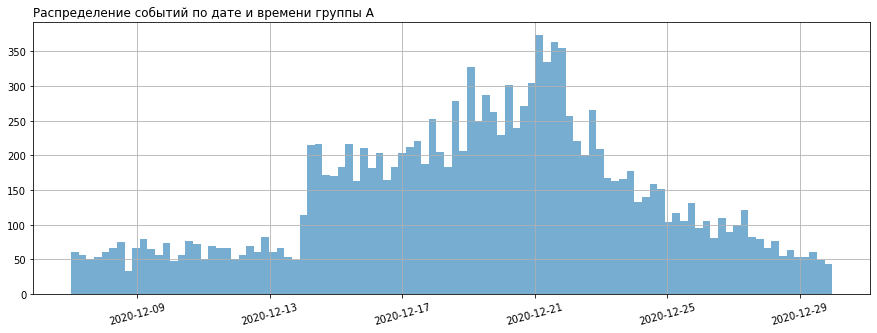

In [51]:
plt.title('Распределение событий по дате и времени группы А', loc='left')
group_a['event_dt'].hist(bins=100, xrot=15,  figsize=(15, 5), alpha=0.6)
plt.show()


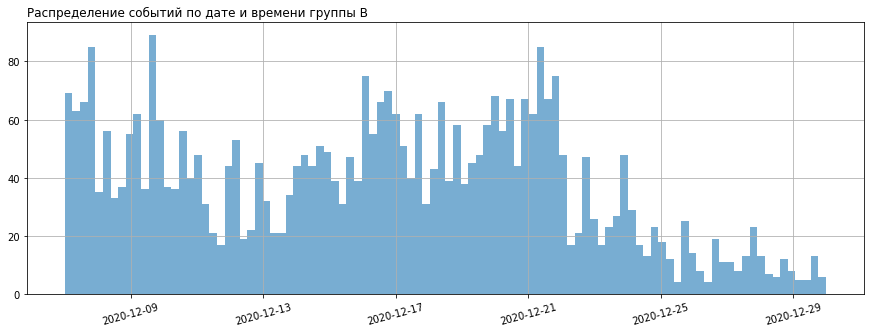

In [52]:
plt.title('Распределение событий по дате и времени группы В', loc='left')
group_b['event_dt'].hist(bins=100, xrot=15,  figsize=(15, 5), alpha=0.6)
plt.show()

События явно не равномерно распределены. Видимо в этот момент начались скидки перед новым годом или очередная черная пятница, кибер понедельник и еще другие интересные эвенты.

In [53]:
mean_a = group_a.groupby('user_id').agg(event_count = ('event_name', 'count')).reset_index()

print(mean_a['event_count'].describe())  


count   2,082.00
mean        6.89
std         3.82
min         1.00
25%         4.00
50%         6.00
75%         9.00
max        24.00
Name: event_count, dtype: float64


In [54]:
mean_b = group_b.groupby('user_id').agg(event_count = ('event_name', 'count')).reset_index()

print(mean_b['event_count'].describe())  

count   706.00
mean      5.40
std       3.26
min       1.00
25%       3.00
50%       4.00
75%       6.00
max      24.00
Name: event_count, dtype: float64


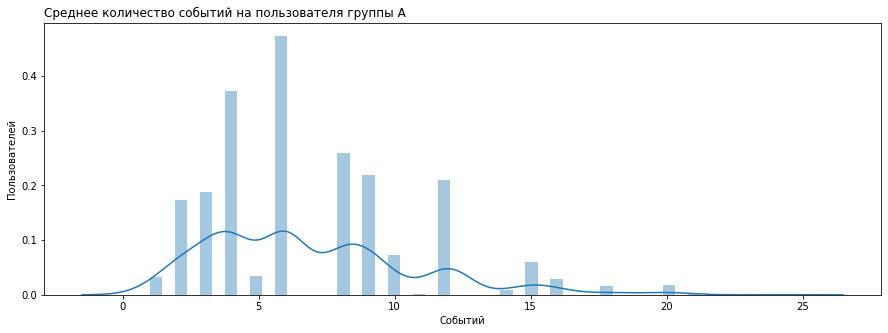

In [55]:
plt.figure(figsize=(15, 5))
plt.title('Cреднее количество событий на пользователя группы А', loc='left')
sns.distplot(mean_a['event_count'], bins=50)
plt.xlabel('Cобытий')                  
plt.ylabel('Пользователей')             
plt.show()

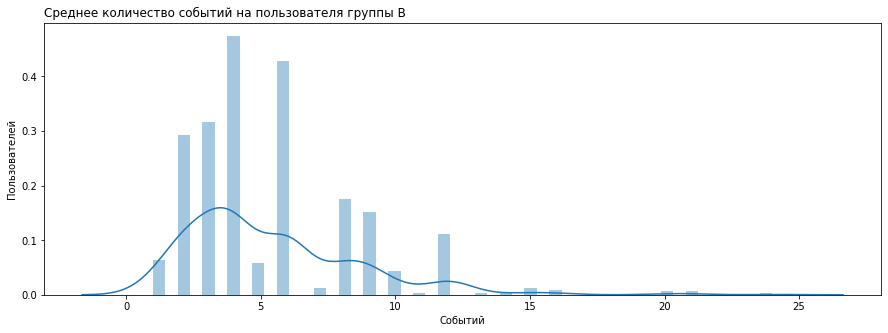

In [56]:
plt.figure(figsize=(15, 5))
plt.title('Cреднее количество событий на пользователя группы В', loc='left')
sns.distplot(mean_b['event_count'], bins=50)
plt.xlabel('Cобытий')                  
plt.ylabel('Пользователей')             
plt.show()

Теперь посмотрим как меняется конверсия в воронке в выборках на разных этапах.

In [57]:
funnel = (events.
              groupby('event_name').
              agg({'user_id': 'nunique'}).
              reset_index().
              rename(columns={'user_id' : 'total_users'}).
              sort_values(by='total_users', ascending=False))
funnel['percent'] = funnel['total_users'] / events['user_id'].nunique() * 100  
funnel

,event_name,total_users,percent
0,login,2787,99.96
2,product_page,1757,63.02
3,purchase,850,30.49
1,product_cart,826,29.63


Залогинились почти все , уже удача )))

Карточку товара посмотрело 63% пользователей

Совершили покупку 30,49 % , что почти на 1% , чем те, что побывал в корзине. Это глюк или можно совершить покупку 1 кнопкой по предварительным настройкам?

На каждом шаге потеря идет 30%

Теперь посмотрим, есть ли разница между группами по конверсии.

In [58]:
funnel_a_b = (events.
          groupby(['event_name', 'group']).
          agg({'user_id': 'nunique'}).
          reset_index().
          rename(columns={'user_id' : 'total_users'}).
          sort_values(by=['group','total_users'], ascending=False))
funnel_a_b

,event_name,group,total_users
1,login,B,705
5,product_page,B,397
7,purchase,B,198
3,product_cart,B,195
0,login,A,2082
4,product_page,A,1360
6,purchase,A,652
2,product_cart,A,631


In [59]:
funnel_a_b['n'] = [1, 2, 4, 3, 1, 2, 4, 3]
funnel_a_b = funnel_a_b.sort_values(by='n')
funnel_a_b

,event_name,group,total_users,n
1,login,B,705,1
0,login,A,2082,1
5,product_page,B,397,2
4,product_page,A,1360,2
3,product_cart,B,195,3
2,product_cart,A,631,3
7,purchase,B,198,4
6,purchase,A,652,4


**Выводы**

У нас было 5099 уникальных участников, а в итоге осталось 2788. Да еще и распределение между группами с разницей почти в 300%.

Данных по событиям не хватает .т.к. в тех задании указано 4 января, мы же видим данные обрываются на 29 декабря.

Так же прослеживаются четкие всплески по дням, что свидетельствует явно не в пользу теста. Подсмотрел в календарь событий, увидел там промо акцию Christmas&New Year Promo. Ну и как можно проводить тест, если не понятно, что повлияло на решение пользователя, акция или все же внедренная рекомендательная система?

Количество участников теста в итоге в 2 раза меньше ожидаемого, 2788 против 6000.

Потеря на этапе логин-карточка товара у группы В больше, чем у А. Покупки схожи.



### Проведение оценки результатов A/B-тестирования

Для проверки статистической разницы долей предлагаю проверить 3 гипотезы о равенстве долей в группах А и В по следующим событиям:

- карточка товара
- корзина
- покупка

Т.к. события 3, то нужно застраховать себя от ложного результата поправкой Бонферрони А/3.


Сформулируем основную и альтернативные гипотезы  для каждой пары:

Нулевая - доли посетителей каждого этапа воронки одинаковы.
Альтернативная - доли отличаются.

In [61]:
def z_test(df1, df2, event, alpha, n):

    bonferroni_alpha = alpha / n
 

    n_users = np.array([df1['user_id'].nunique(), 
                        df2['user_id'].nunique()])


    success = np.array([df1[df1['event_name'] == event]['user_id'].nunique(), 
                        df2[df2['event_name'] == event]['user_id'].nunique()])


    p1 = success[0]/n_users[0]
    p2 = success[1]/n_users[1]
    

    p_combined = (success[0] + success[1]) / (n_users[0] + n_users[1])
    

    difference = p1 - p2 
    

    z_value = difference /  np.sqrt(p_combined * (1 - p_combined) * (1/n_users[0] + 1/n_users[1]))
    

    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2   #тест двусторонний, удваиваем результат
    
    print('Событие:', event)
    print('p-значение: ', p_value)

    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')


In [62]:
for event in ['product_page', 'product_cart', 'purchase']:
    z_test(events[events['group'] == 'A'], events[events['group'] == 'B'], event,.05, 3)
    print()


Событие: product_page
p-значение:  1.5371909704686715e-05
Отвергаем нулевую гипотезу: между долями есть разница

Событие: product_cart
p-значение:  0.1766337419130104
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: purchase
p-значение:  0.10281767567786759
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Выводы**

Что можно сказать про результаты A/B-тестирования?

На этапе карточки товара есть разница между долями, соответсвенно я бы уже по этому признаку не стал бы доверять тесту.

Так же группа В показала хуже конверсию, а это значит, что при равных группах , не работает наша новая система рекомендаций, но и тут есть Но, были праздники и маркетинг запустил свое промо.

Про пересечение между разными тестами и неполноту данных я уже тоже писал.

### Общее заключение о корректности проведения теста.

Считаю, что тест проведен некорректно:
- Тест проводился во время предновогодних распродаж, при этам маркетинг запустил еще и промо акцию
- Данные по событиям заканчиваются 29 декабря, хотя по заданию нужно было закончить тест 4 января
- У нас пересечение пользователей двух тестов, из-за чего мне пришлось часть пользователей дропнуть.
- Разница между распределением по группам очень существенная
- Количество активных участников 2 раза меньше, чем в тех. задании.

Сам же тест показал, что конверсия у группы В даже хуже, чем у А для этапа просмотра карточки товара.
И проверка гипотезы по равенству долей , показала разницу между группами , причем в пользу А группы.
На других этапах она не изменилась. Соответсвенно улучшение метрики в 10% не произошло.

**Общий итог, что тест не очень, что нововведение...**